<a href="https://colab.research.google.com/github/Gabs-Dimitri/ANN-MNIST/blob/main/ANN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# ANN

## Carregando dados do tensorflow

Os dados do mnist no tensorflow estão disponibilizados da seguinte maneira: 60000 instâncias para treino e 10000 para teste. Logo, fazemos a concatenação dos dados para armazenar tudo em uma variável x (imagens) e uma variável y (rótulos).

In [2]:
(x_tr, y_tr), (x_t, y_t) = mnist.load_data()

In [3]:
x = np.concatenate((x_tr, x_t), axis=0)
y = np.concatenate((y_tr, y_t), axis=0)

## Padronização dos dados

Valores dos pixels nas imagens estão na faixa de 0 a 255.

In [4]:
x = x / 255.0

## Split

In [5]:
x_ann_train, x_ann_test, y_ann_train, y_ann_test = train_test_split(x, y, test_size=0.25, random_state=0)

## Modelo

* Camada de entrada $Flatten$ para transformar uma matriz bidimensional em um vetor unidimensional. A camada $Flatten$ é usada para preparar os dados de entrada de uma rede neural convolucional para serem usados por uma árvore de decisão ou outro modelo de aprendizado de máquina que espera uma entrada unidimensional;

* Camadas ocultas com ativação $ReLU$, comumente usada em camadas ocultas de redes neurais para introduzir não linearidade e capturar padrões complexos nos dados;

* Camada de saída com ativação $Softmax$, comumente usada para problemas de classificação multiclasse, onde estamos tentando prever a probabilidade de cada classe.  

In [6]:
model = Sequential([
  Flatten(input_shape=(28, 28)),  # Camada de entrada (transforma a matriz 28x28 em vetor de 784 elementos)
  Dense(128, activation='relu'),  # Primeira camada oculta com 128 neurônios e ativação ReLU
  Dense(64, activation='relu'),   # Segunda camada oculta com 64 neurônios e ativação ReLU
  Dense(10, activation='softmax') # Camada de saída com 10 neurônios (um para cada classe) e ativação softmax
])

## Compilando modelo

Perda usando uma função para problemas de classificação multiclasse.

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Função de perda para problemas de classificação multiclasse
              metrics=['accuracy'])

## Treino do modelo

In [8]:
model.fit(x_ann_train, y_ann_train, epochs=5, validation_data=(x_ann_test, y_ann_test))

Epoch 1/5
1641/1641 [==============================] - 13s 7ms/step - loss: 0.2558 - accuracy: 0.9256 - val_loss: 0.1441 - val_accuracy: 0.9543
Epoch 2/5
1641/1641 [==============================] - 7s 4ms/step - loss: 0.1077 - accuracy: 0.9676 - val_loss: 0.1346 - val_accuracy: 0.9577
Epoch 3/5
1641/1641 [==============================] - 6s 4ms/step - loss: 0.0734 - accuracy: 0.9774 - val_loss: 0.0969 - val_accuracy: 0.9699
Epoch 4/5
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0554 - accuracy: 0.9824 - val_loss: 0.0907 - val_accuracy: 0.9731
Epoch 5/5
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0433 - accuracy: 0.9855 - val_loss: 0.0965 - val_accuracy: 0.9725


## Prevendo resultados

Como as previsões do modelo são probabilidades para cada classe, usamos o **argmax** do numpy para converter as previsões de probabilidades para rótulos de classe.

In [9]:
y_ann_pred = model.predict(x)
y_ann_pred_labels = np.argmax(y_ann_pred, axis=1)

2188/2188 [==============================] - 4s 2ms/step


## Matriz de confusão e acurácia

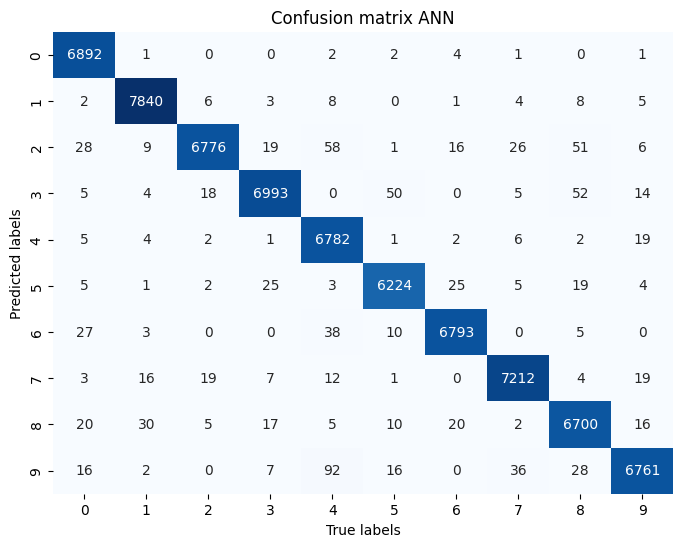

Acurácia: 0.985329


In [10]:
cm_ann = confusion_matrix(y, y_ann_pred_labels)
nome_modelo = 'Confusion matrix ANN'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y
plt.ylabel('Predicted labels')  # y_ann_pred_labels
plt.title(nome_modelo)
plt.show()

acc_ann = accuracy_score(y, y_ann_pred_labels)
print('Acurácia:', round(acc_ann, 6))

## Visualização

4/4 [==============================] - 0s 3ms/step


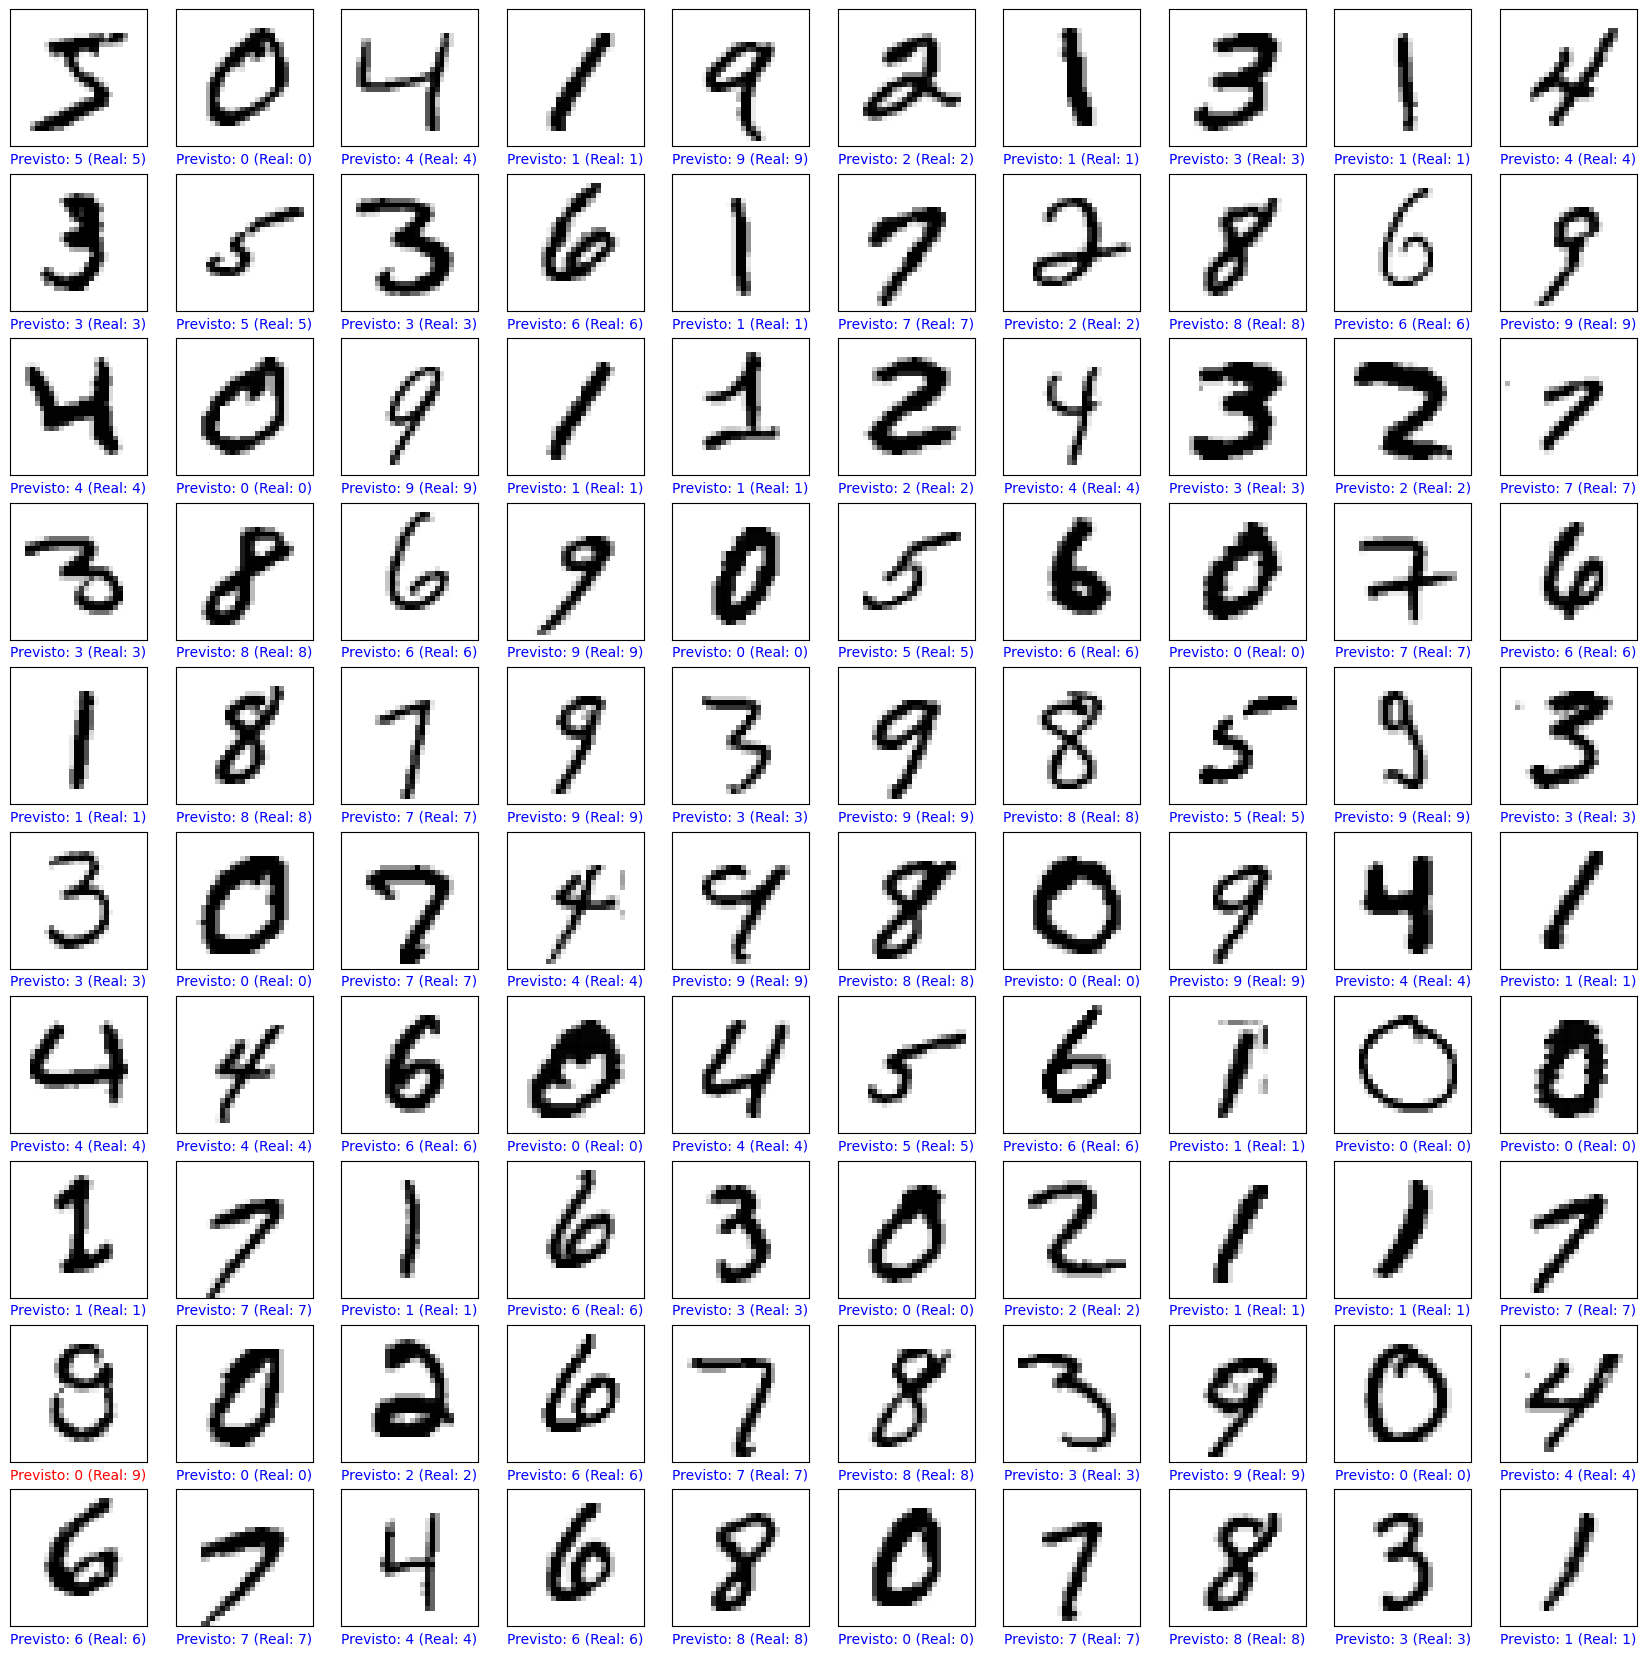

In [11]:
# Previsões para as primeiras n imagens do conjunto
predictions_ann = model.predict(x[:100])

# Visualização das previsões e dos rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[i], cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_ann[i])
  true_label = y[i]
  color = 'blue' if predicted_label == true_label else 'red'
  plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Árvore com base na rede neural

## Redimensionamento

Como x é uma matriz tridimensional e o classificador da árvore aceita dados bidimensionais ou menores, precisamos fazer o reshape dos dados.

In [12]:
n_samples = x.shape[0]                                    # Número de imagens
width = x.shape[1]                                        # Largura das imagens
height = x.shape[2]                                       # Altura das imagens
x_tree = np.reshape(x, (n_samples, width * height))       # Número de imagens, quantidade de pixels

## Split

Usando os rótulos previstos pela rede.

In [13]:
x_tree_ann_train, x_tree_ann_test, y_tree_ann_train, y_tree_ann_test = train_test_split(x_tree, y_ann_pred_labels, test_size=0.25, random_state=0)

## Treinamento da árvore

In [14]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_tree_ann_train, y_tree_ann_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

## Prevendo resultados

In [15]:
y_tree_ann_pred = classifier.predict(x_tree)

## Matriz de confusão e acurácia

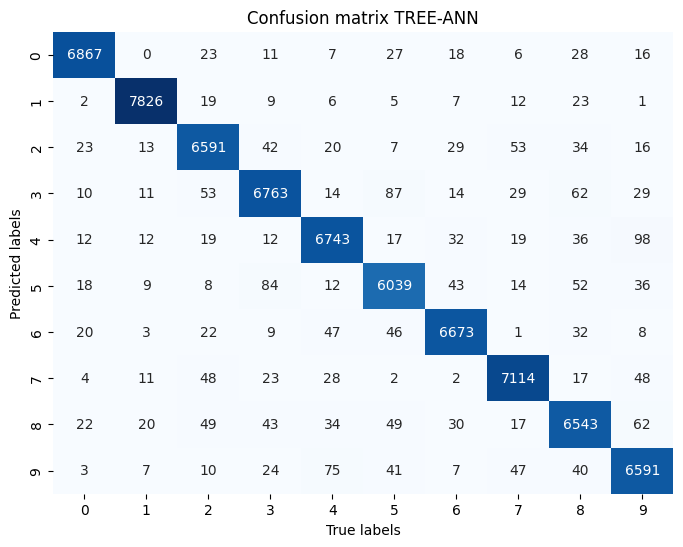

Acurácia: 0.967857


In [16]:
cm_tree_ann = confusion_matrix(y_ann_pred_labels, y_tree_ann_pred)
nome_modelo = 'Confusion matrix TREE-ANN'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree_ann, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_ann_pred_labels
plt.ylabel('Predicted labels')  # y_tree_ann_pred
plt.title(nome_modelo)
plt.show()

acc_tree_ann = accuracy_score(y_ann_pred_labels, y_tree_ann_pred)
print('Acurácia:', round(acc_tree_ann, 6))

## Visualização

In [17]:
x_tree_reshaped = x_tree.reshape(-1, 28, 28)

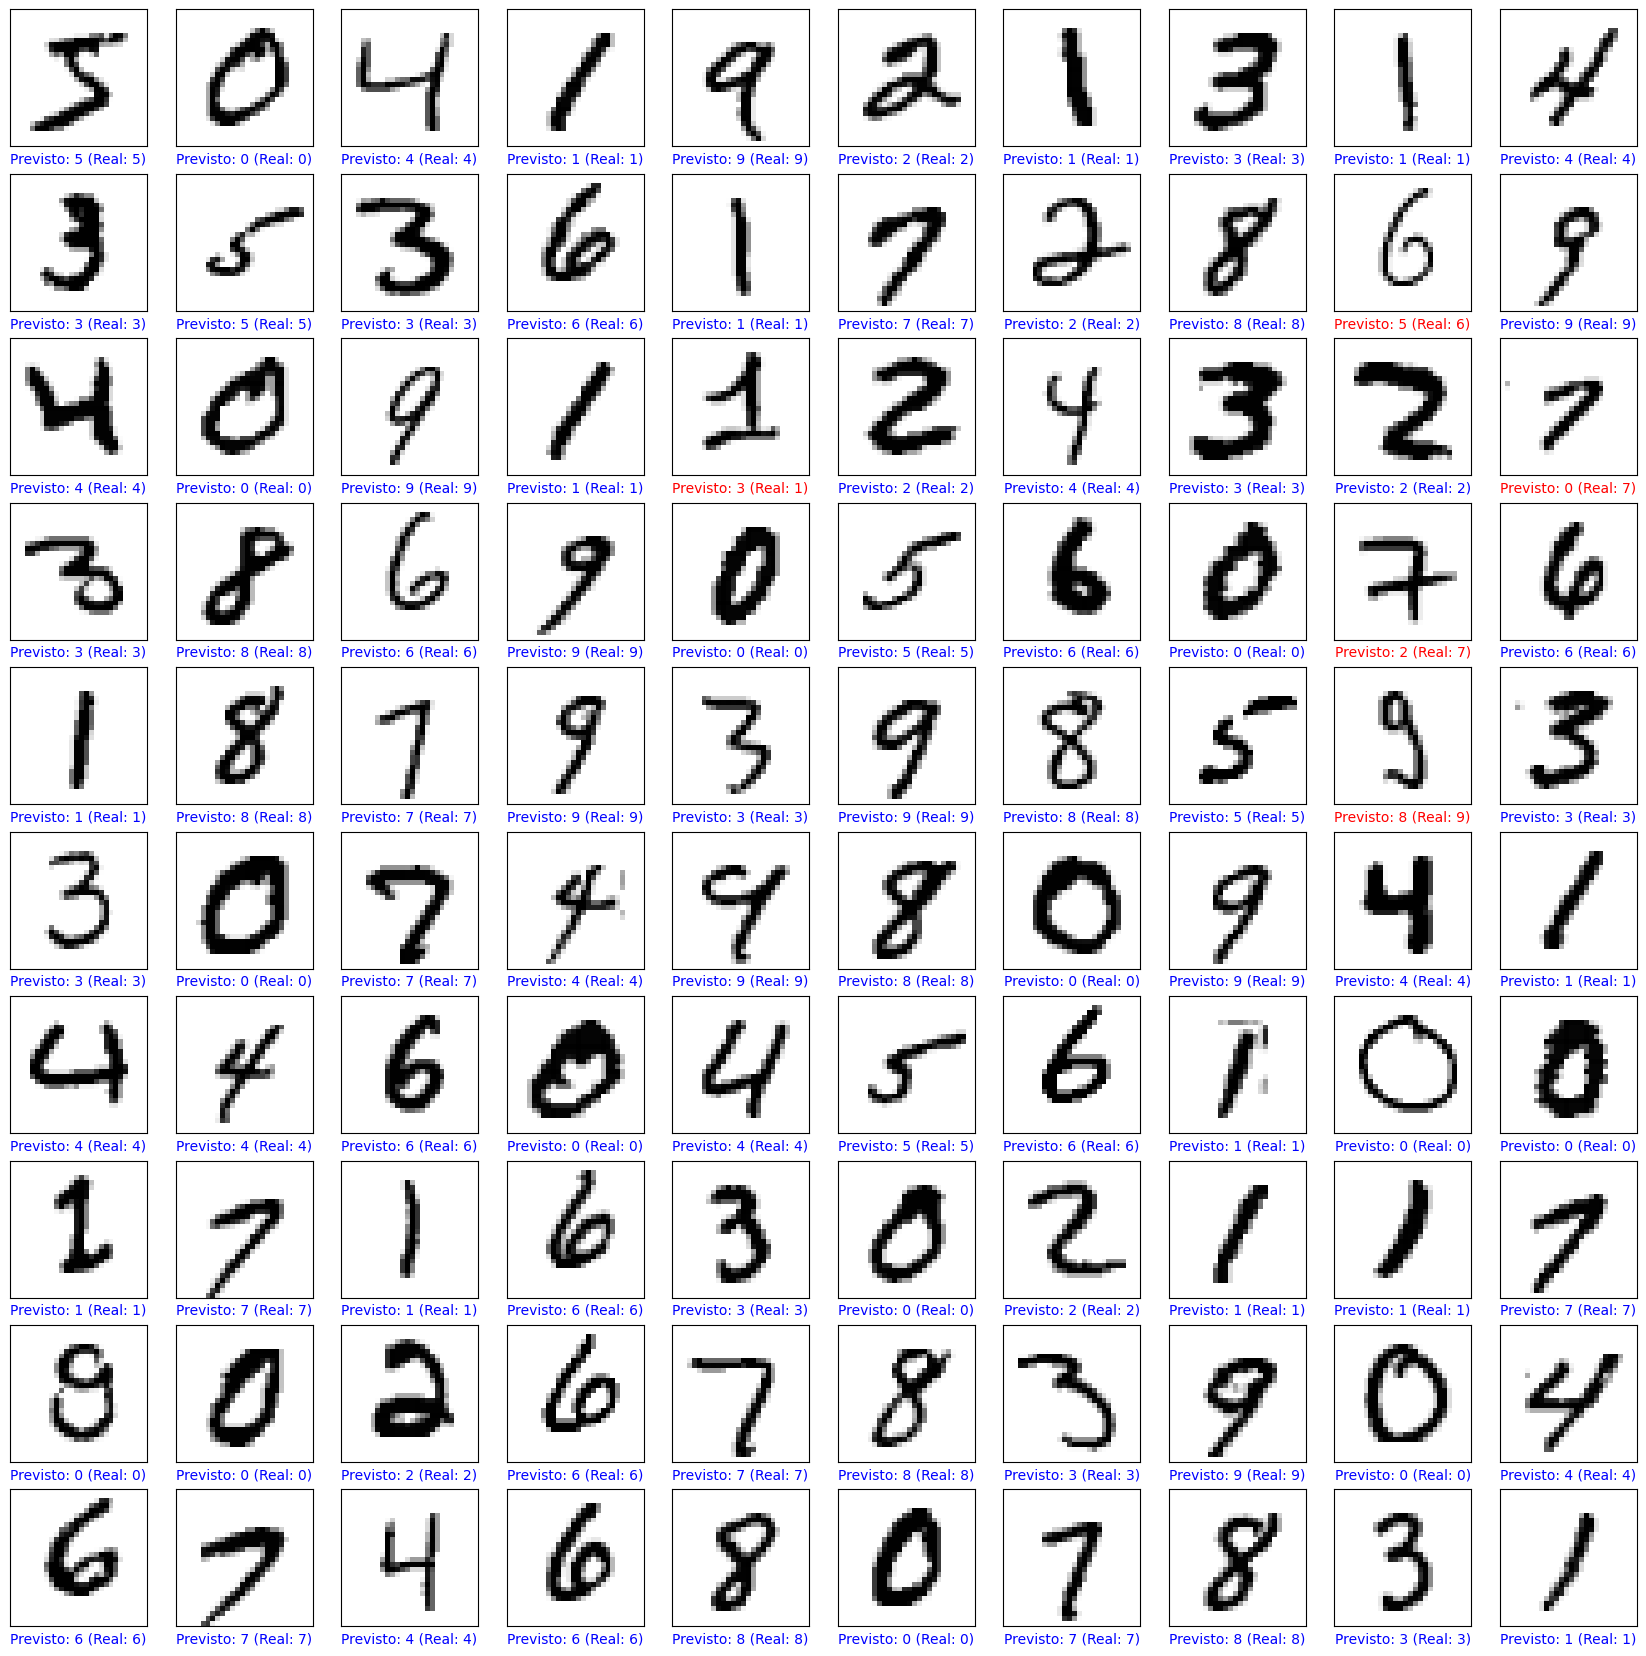

In [18]:
predictions_tree_ann = classifier.predict(x_tree[:100])

# Visualizar as previsões e os rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_tree_reshaped[i], cmap=plt.cm.binary)
    predicted_label = predictions_tree_ann[i]
    true_label = y_ann_pred_labels[i]
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Comparação ANN / árvore

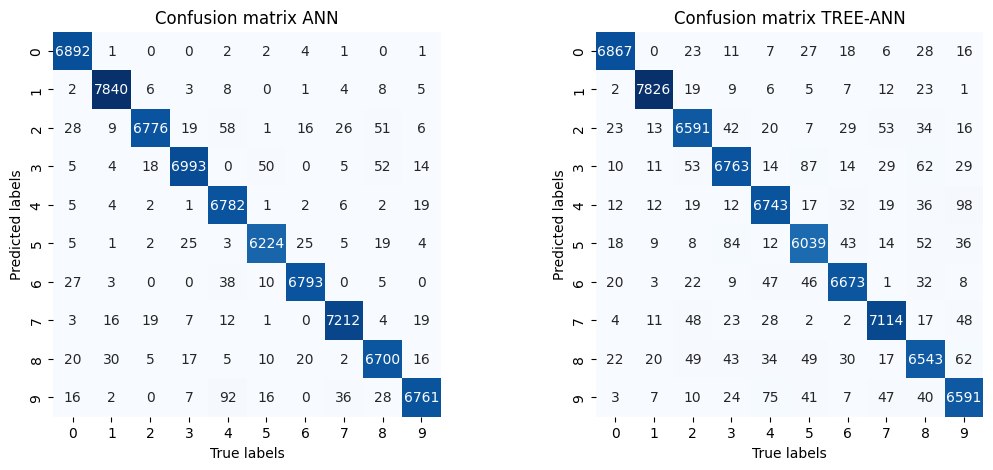

,Acurácia_ANN,Acurácia_TREE-ANN
0,0.985329,0.967857


In [19]:
matrizes_confusao = [cm_ann, cm_tree_ann]
nomes_matrizes = ['Confusion matrix ANN', 'Confusion matrix TREE-ANN']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, cm, nome_modelo in zip(axs.flatten(), matrizes_confusao, nomes_matrizes):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.set_title(nome_modelo)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

acuracia = [(acc_ann, acc_tree_ann)]
df = pd.DataFrame(acuracia, columns=('Acurácia_ANN', 'Acurácia_TREE-ANN'))
df

# Árvore com base nos dados originais

Aproveitando alguns dados já escritos, podemos ir direto para o split dos dados.

## Split

Usando os rótulos originais.

In [20]:
x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(x_tree, y, test_size=0.25, random_state=0)

## Treinando

In [21]:
classifier.fit(x_tree_train, y_tree_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

## Prevendo resultados

In [22]:
y_tree_pred = classifier.predict(x_tree)

## Matriz de confusão e acurácia

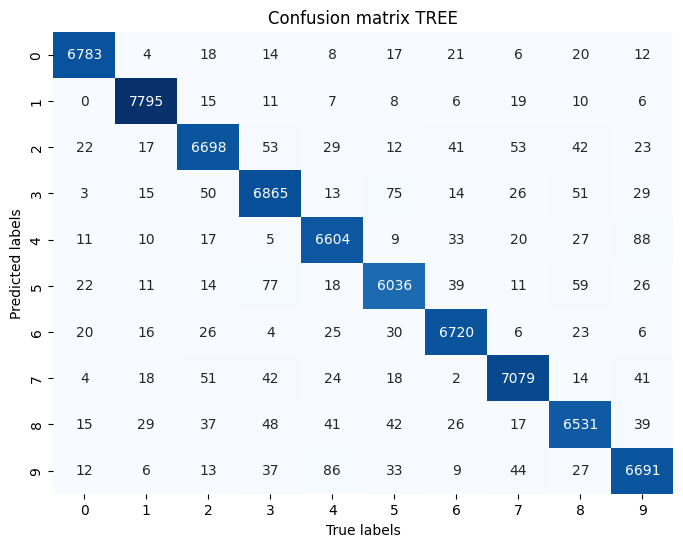

Acurácia: 0.9686


In [23]:
cm_tree = confusion_matrix(y, y_tree_pred)
nome_modelo = 'Confusion matrix TREE'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y
plt.ylabel('Predicted labels')  # y_tree_pred
plt.title(nome_modelo)
plt.show()

acc_tree = accuracy_score(y, y_tree_pred)
print('Acurácia:', round(acc_tree, 6))

## Visualização

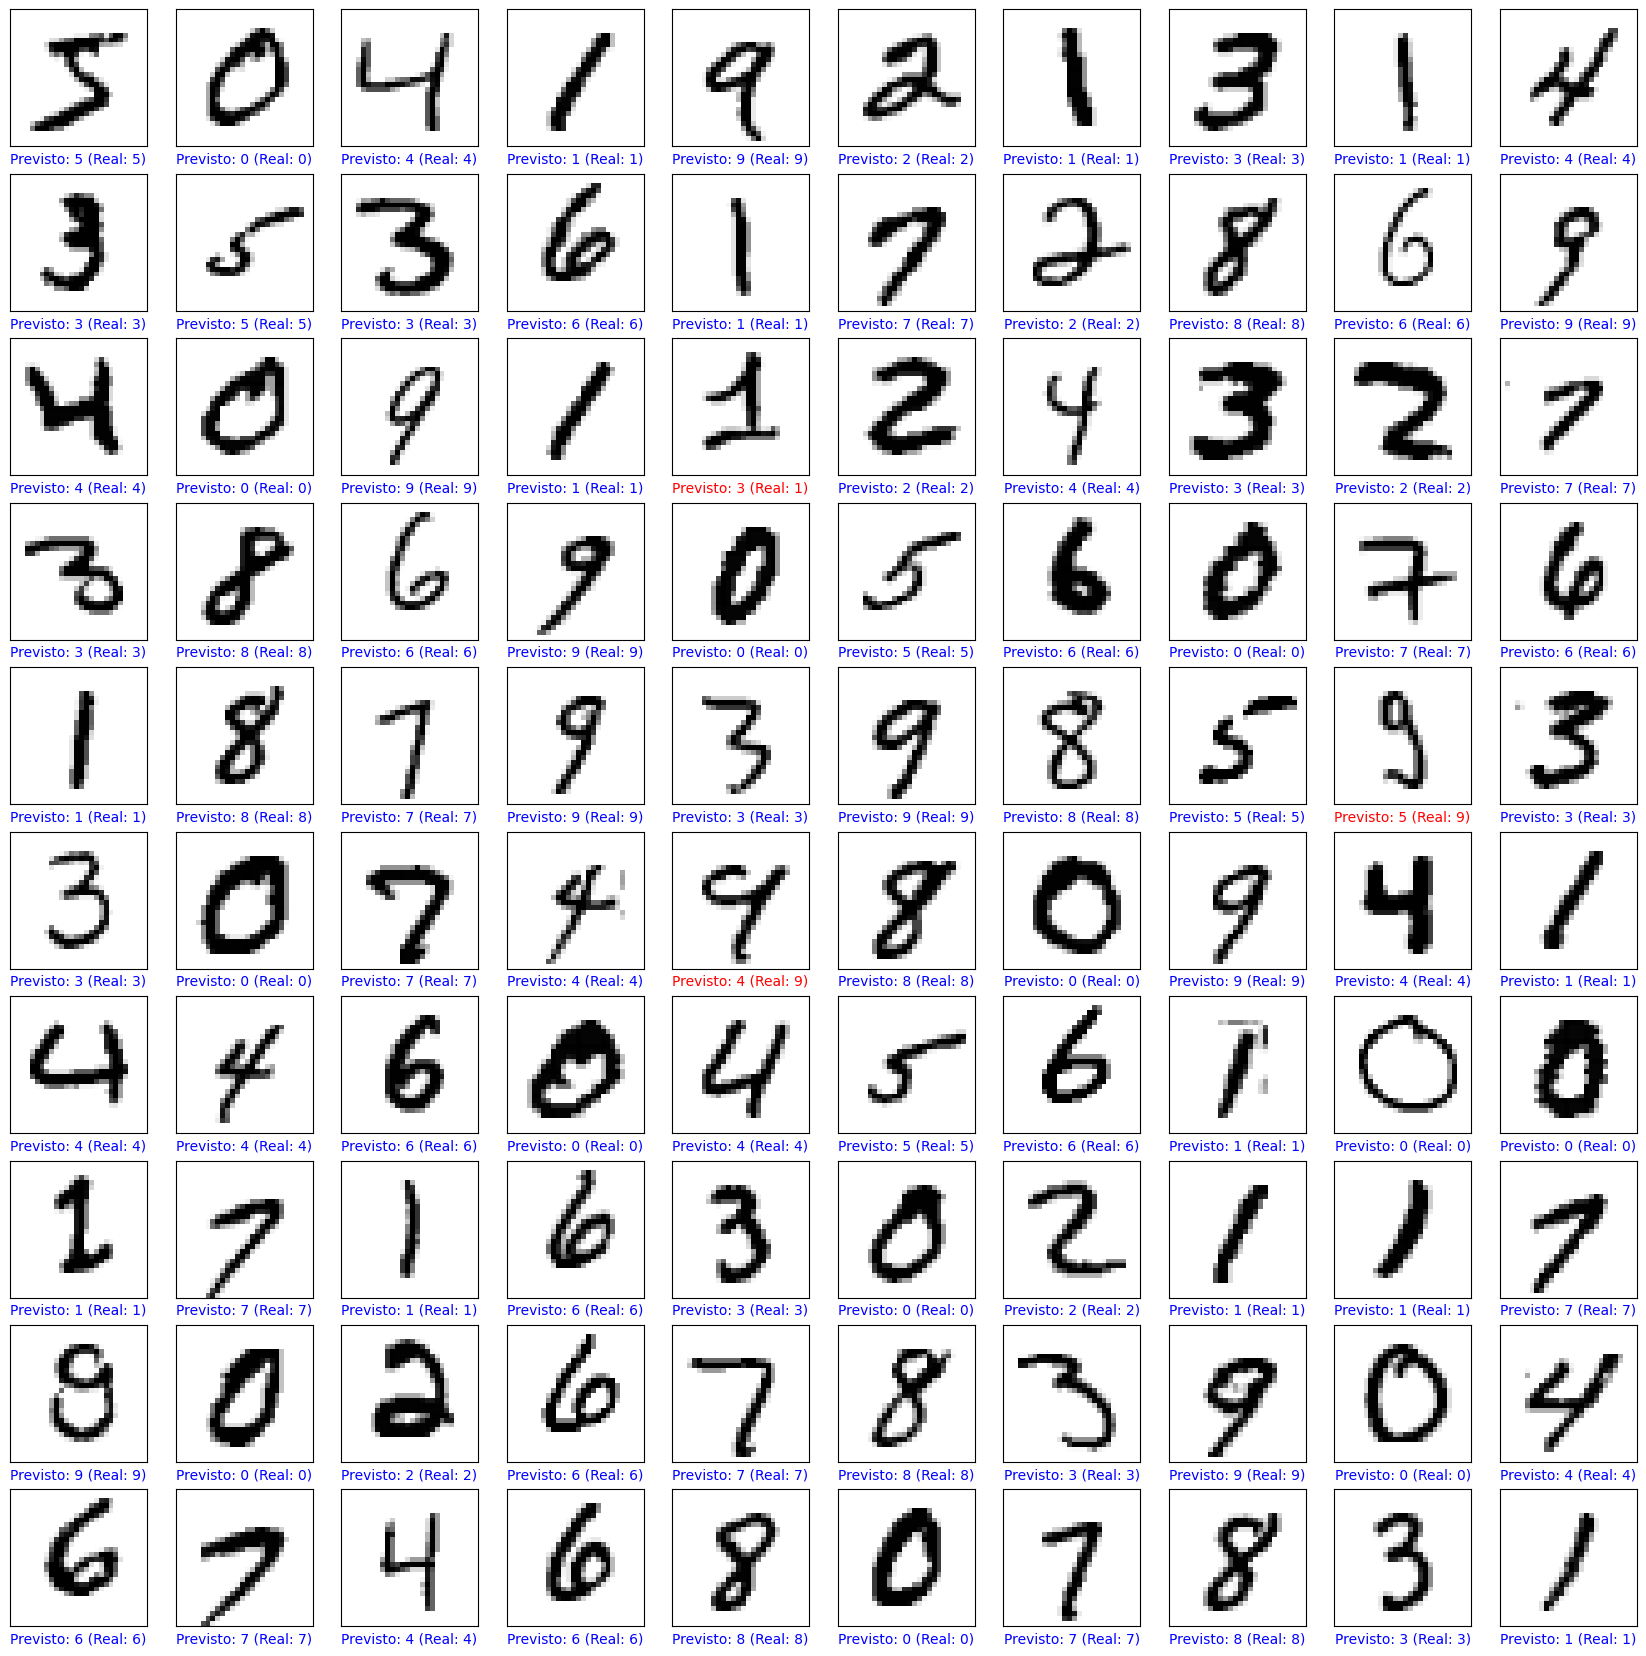

In [24]:
predictions_tree = classifier.predict(x_tree[:100])

# Visualizar as previsões e os rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_tree_reshaped[i], cmap=plt.cm.binary)
    predicted_label = predictions_tree[i]
    true_label = y[i]
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Comparação das árvores

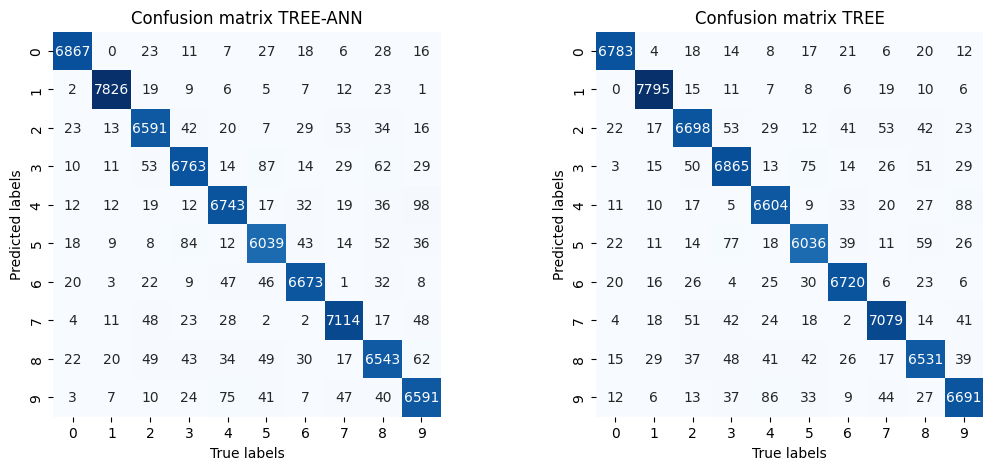

,Acuracia_TREE-ANN,Acuracia_TREE
0,0.967857,0.9686


In [25]:
matrizes_confusao = [cm_tree_ann, cm_tree]
nomes_matrizes = ['Confusion matrix TREE-ANN', 'Confusion matrix TREE']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, cm, nome_modelo in zip(axs.flatten(), matrizes_confusao, nomes_matrizes):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.set_title(nome_modelo)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

acuracia = [(acc_tree_ann, acc_tree)]
df = pd.DataFrame(acuracia, columns=('Acuracia_TREE-ANN', 'Acuracia_TREE'))
df

# Adicionando dados fictícios

Gerar dados aleatórios de imagens é algo complicado, dado que são pixels. Sendo assim, foram criados imagens totalmente aleatórias, mas com rótulos previstos pelo modelo ANN.  

## Abrindo novamente os dados

In [26]:
(x_tr, y_tr), (x_t, y_t) = mnist.load_data()

In [27]:
x = np.concatenate((x_tr, x_t), axis=0)
y = np.concatenate((y_tr, y_t), axis=0)

## Gerando n dados fictícios

In [28]:
dados_ficticios = 10000     # Número de dados fictícios a serem gerados
tam_imagem = x.shape[1:]    # Tamanho das imagens do mnist para gerar imagens com o mesmo tamanho

In [29]:
x_ficticio = np.random.randint(0, 256, size=(dados_ficticios, *tam_imagem))    # Gerando imagens fictícias aleatórias

## Prevendo y

In [30]:
y_ficticio_pred = model.predict(x_ficticio)
y_ficticio_pred_labels = np.argmax(y_ficticio_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


## Concatenando com os dados originais

In [31]:
x_total = np.concatenate((x, x_ficticio), axis=0)
y_total = np.concatenate((y, y_ficticio_pred_labels), axis=0)

In [32]:
print("Dados de imagens:", x_total.shape)
print("Dados dos rótulos:", y_total.shape)

Dados de imagens: (80000, 28, 28)
Dados dos rótulos: (80000,)


## Normalizando

In [33]:
x_total = x_total / 255

## Reshape de x

In [34]:
n_samples = x_total.shape[0]
width = x_total.shape[1]
height = x_total.shape[2]
x_total_reshaped = np.reshape(x_total, (n_samples, width * height))

## Split

In [35]:
x_treef_train, x_treef_test, y_treef_train, y_treef_test = train_test_split(x_total_reshaped, y_total, test_size=0.25, random_state=0)

## Treinamento

In [36]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_treef_train, y_treef_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

## Prevendo resultados

In [37]:
y_treef_pred = classifier.predict(x_total_reshaped)

## Matriz de confusão e acurácia

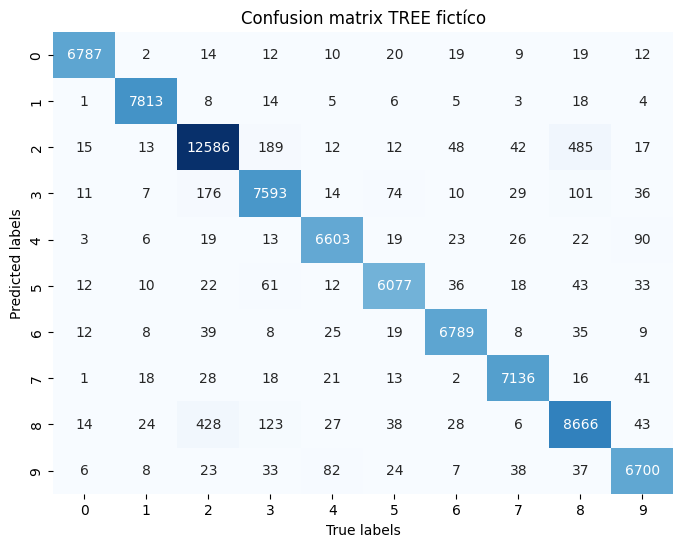

Acurácia: 0.959375


In [38]:
cm_tree_f = confusion_matrix(y_total, y_treef_pred)
nome_modelo = 'Confusion matrix TREE fictíco'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree_f, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_total
plt.ylabel('Predicted labels')  # y_treef_pred
plt.title(nome_modelo)
plt.show()

acc_tree_f = accuracy_score(y_total, y_treef_pred)
print('Acurácia:', round(acc_tree_f, 6))

## Visualização

In [39]:
x_treef_reshaped = x_total_reshaped.reshape(-1, 28, 28)

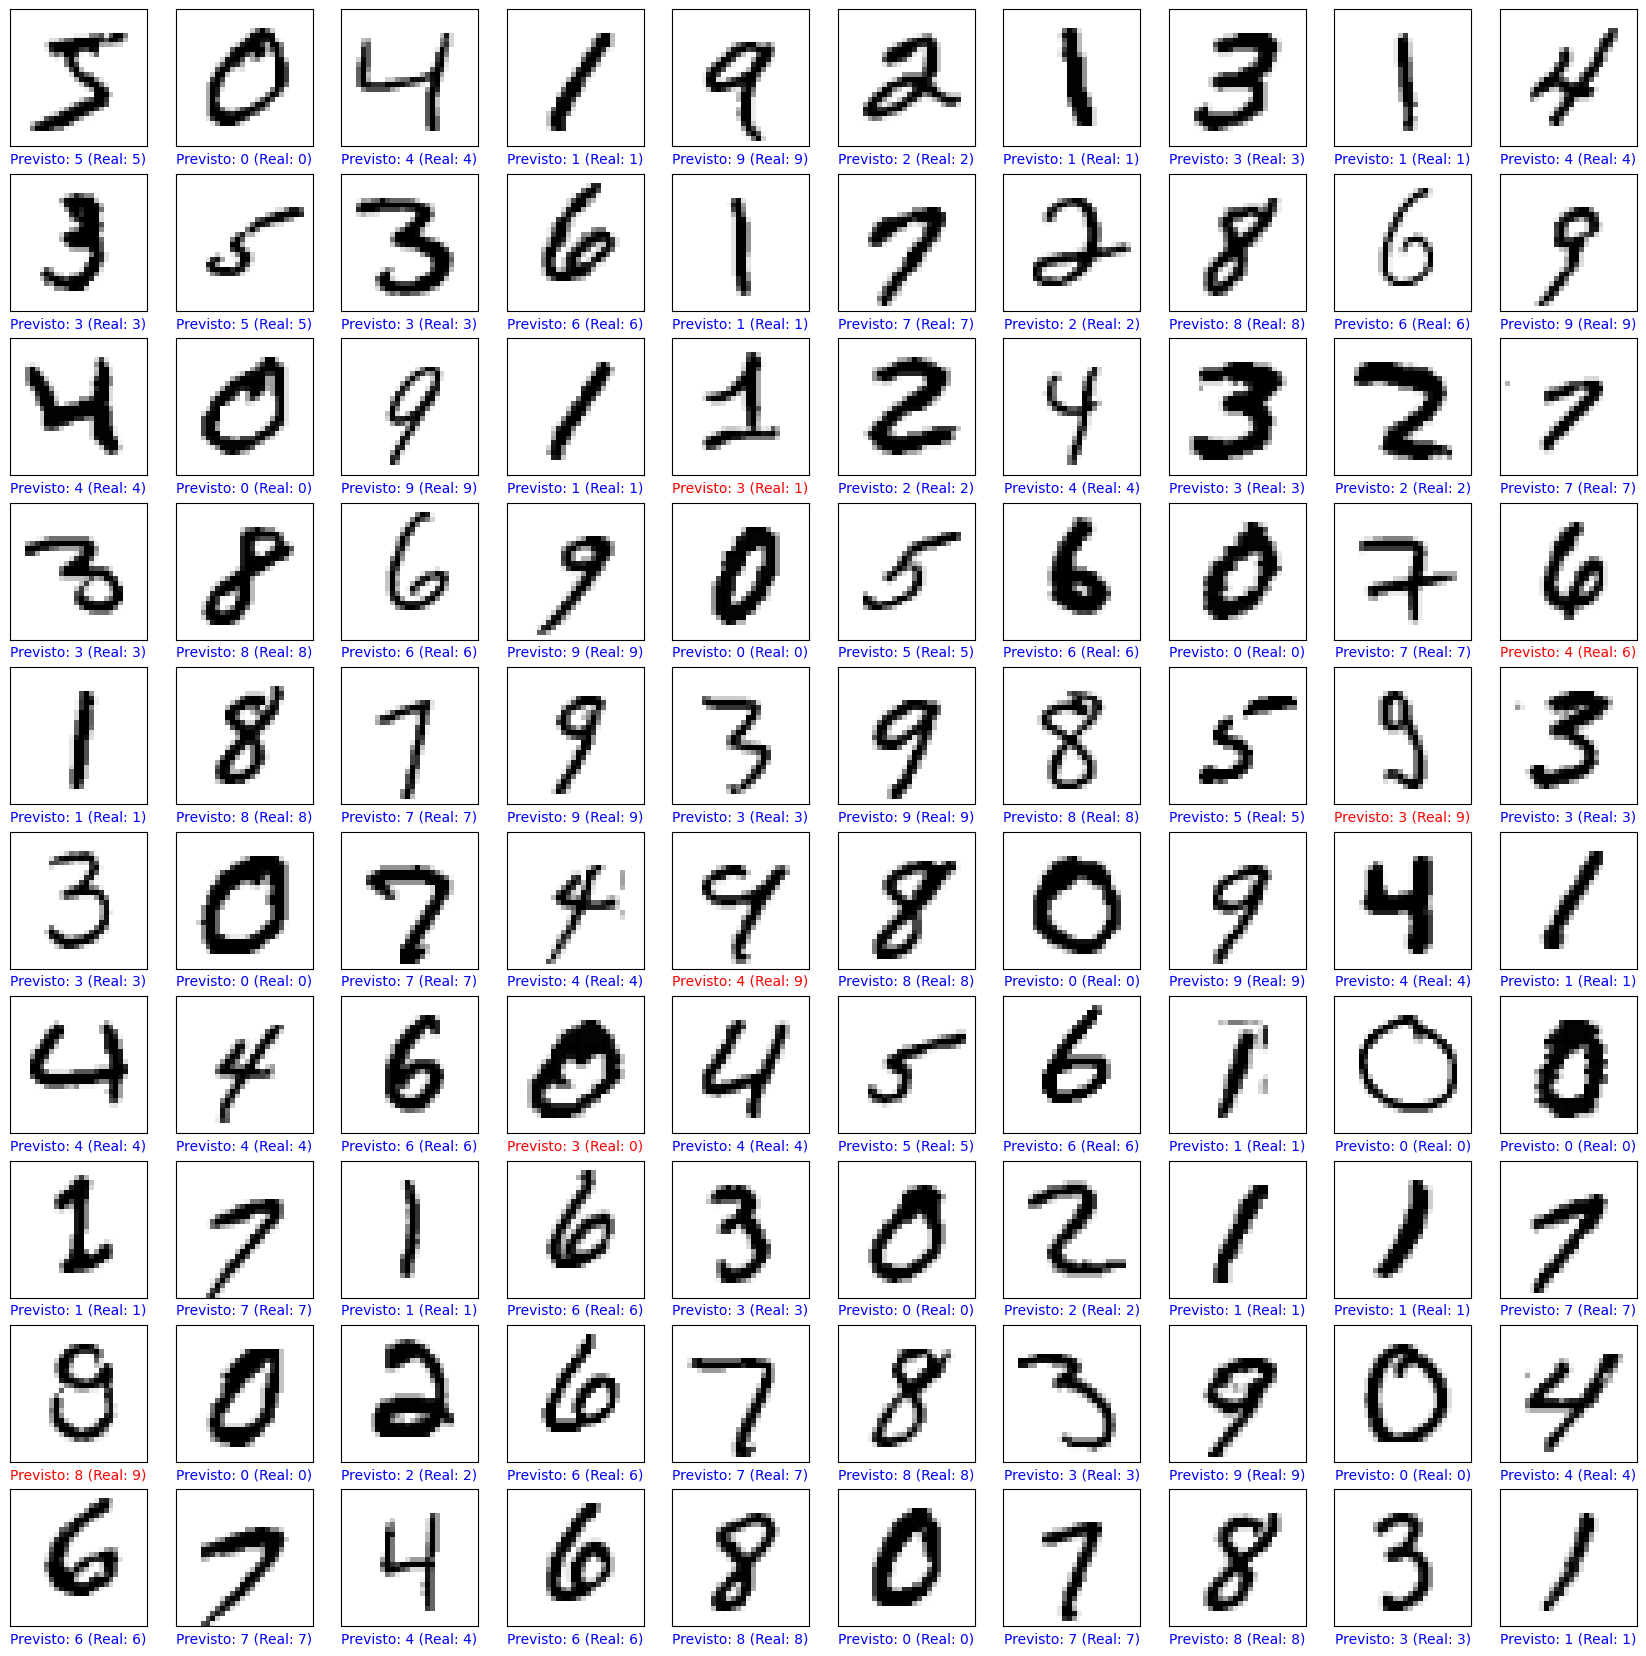

In [40]:
predictions_f = classifier.predict(x_total_reshaped[:100])

# Visualizar as previsões e os rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_treef_reshaped[i], cmap=plt.cm.binary)
    predicted_label = predictions_f[i]
    true_label = y_total[i]
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# ANN com 30 mil instâncias

## Abrindo conjunto de dados

In [41]:
(x_tr, y_tr), (x_t, y_t) = mnist.load_data()
x = np.concatenate((x_tr, x_t), axis=0)
y = np.concatenate((y_tr, y_t), axis=0)

## Selecionando 30000 instâncias

In [42]:
x_trinta = x[:30000]
y_trinta = y[:30000]

## Normalizando

In [43]:
x_trinta = x_trinta / 255.0

## Split

In [44]:
x_trinta_ann_train, x_trinta_ann_test, y_trinta_ann_train, y_trinta_ann_test = train_test_split(x_trinta, y_trinta, test_size=0.25, random_state=0)

## Modelo

Para manter organizado, vamos apenas alterar a variável em que o modelo está sendo feito.

In [45]:
model_trinta = Sequential([
  Flatten(input_shape=(28, 28)),  # Camada de entrada (transforma a matriz 28x28 em vetor de 784 elementos)
  Dense(128, activation='relu'),  # Primeira camada oculta com 128 neurônios e ativação ReLU
  Dense(64, activation='relu'),   # Segunda camada oculta com 64 neurônios e ativação ReLU
  Dense(10, activation='softmax') # Camada de saída com 10 neurônios (um para cada classe) e ativação softmax
])

## Compilando modelo

In [46]:
model_trinta.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Função de perda para problemas de classificação multiclasse
              metrics=['accuracy'])

## Treinamento

In [47]:
model_trinta.fit(x_trinta_ann_train, y_trinta_ann_train, epochs=5, validation_data=(x_trinta_ann_test, y_trinta_ann_test))

Epoch 1/5
704/704 [==============================] - 4s 4ms/step - loss: 0.3725 - accuracy: 0.8913 - val_loss: 0.1876 - val_accuracy: 0.9479
Epoch 2/5
704/704 [==============================] - 3s 4ms/step - loss: 0.1563 - accuracy: 0.9536 - val_loss: 0.1652 - val_accuracy: 0.9517
Epoch 3/5
704/704 [==============================] - 4s 6ms/step - loss: 0.1081 - accuracy: 0.9668 - val_loss: 0.1325 - val_accuracy: 0.9597
Epoch 4/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0762 - accuracy: 0.9769 - val_loss: 0.1182 - val_accuracy: 0.9652
Epoch 5/5
704/704 [==============================] - 3s 4ms/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.1058 - val_accuracy: 0.9684


## Prevendo resultados

In [48]:
y_trinta_ann_pred = model_trinta.predict(x_trinta)
y_trinta_ann_pred_labels = np.argmax(y_trinta_ann_pred, axis=1)

938/938 [==============================] - 2s 2ms/step


## Matriz de confusão e acurária

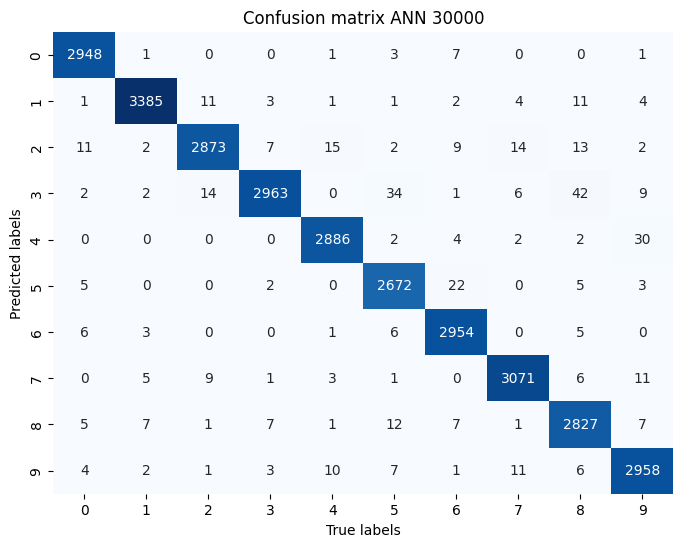

Acurácia: 0.984567


In [49]:
cm_trinta_ann = confusion_matrix(y_trinta, y_trinta_ann_pred_labels)
nome_modelo = 'Confusion matrix ANN 30000'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_trinta_ann, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_trinta
plt.ylabel('Predicted labels')  # y_trinta_ann_pred_labels
plt.title(nome_modelo)
plt.show()

acc_trinta_ann = accuracy_score(y_trinta, y_trinta_ann_pred_labels)
print('Acurácia:', round(acc_trinta_ann, 6))

## Visualização

4/4 [==============================] - 0s 3ms/step


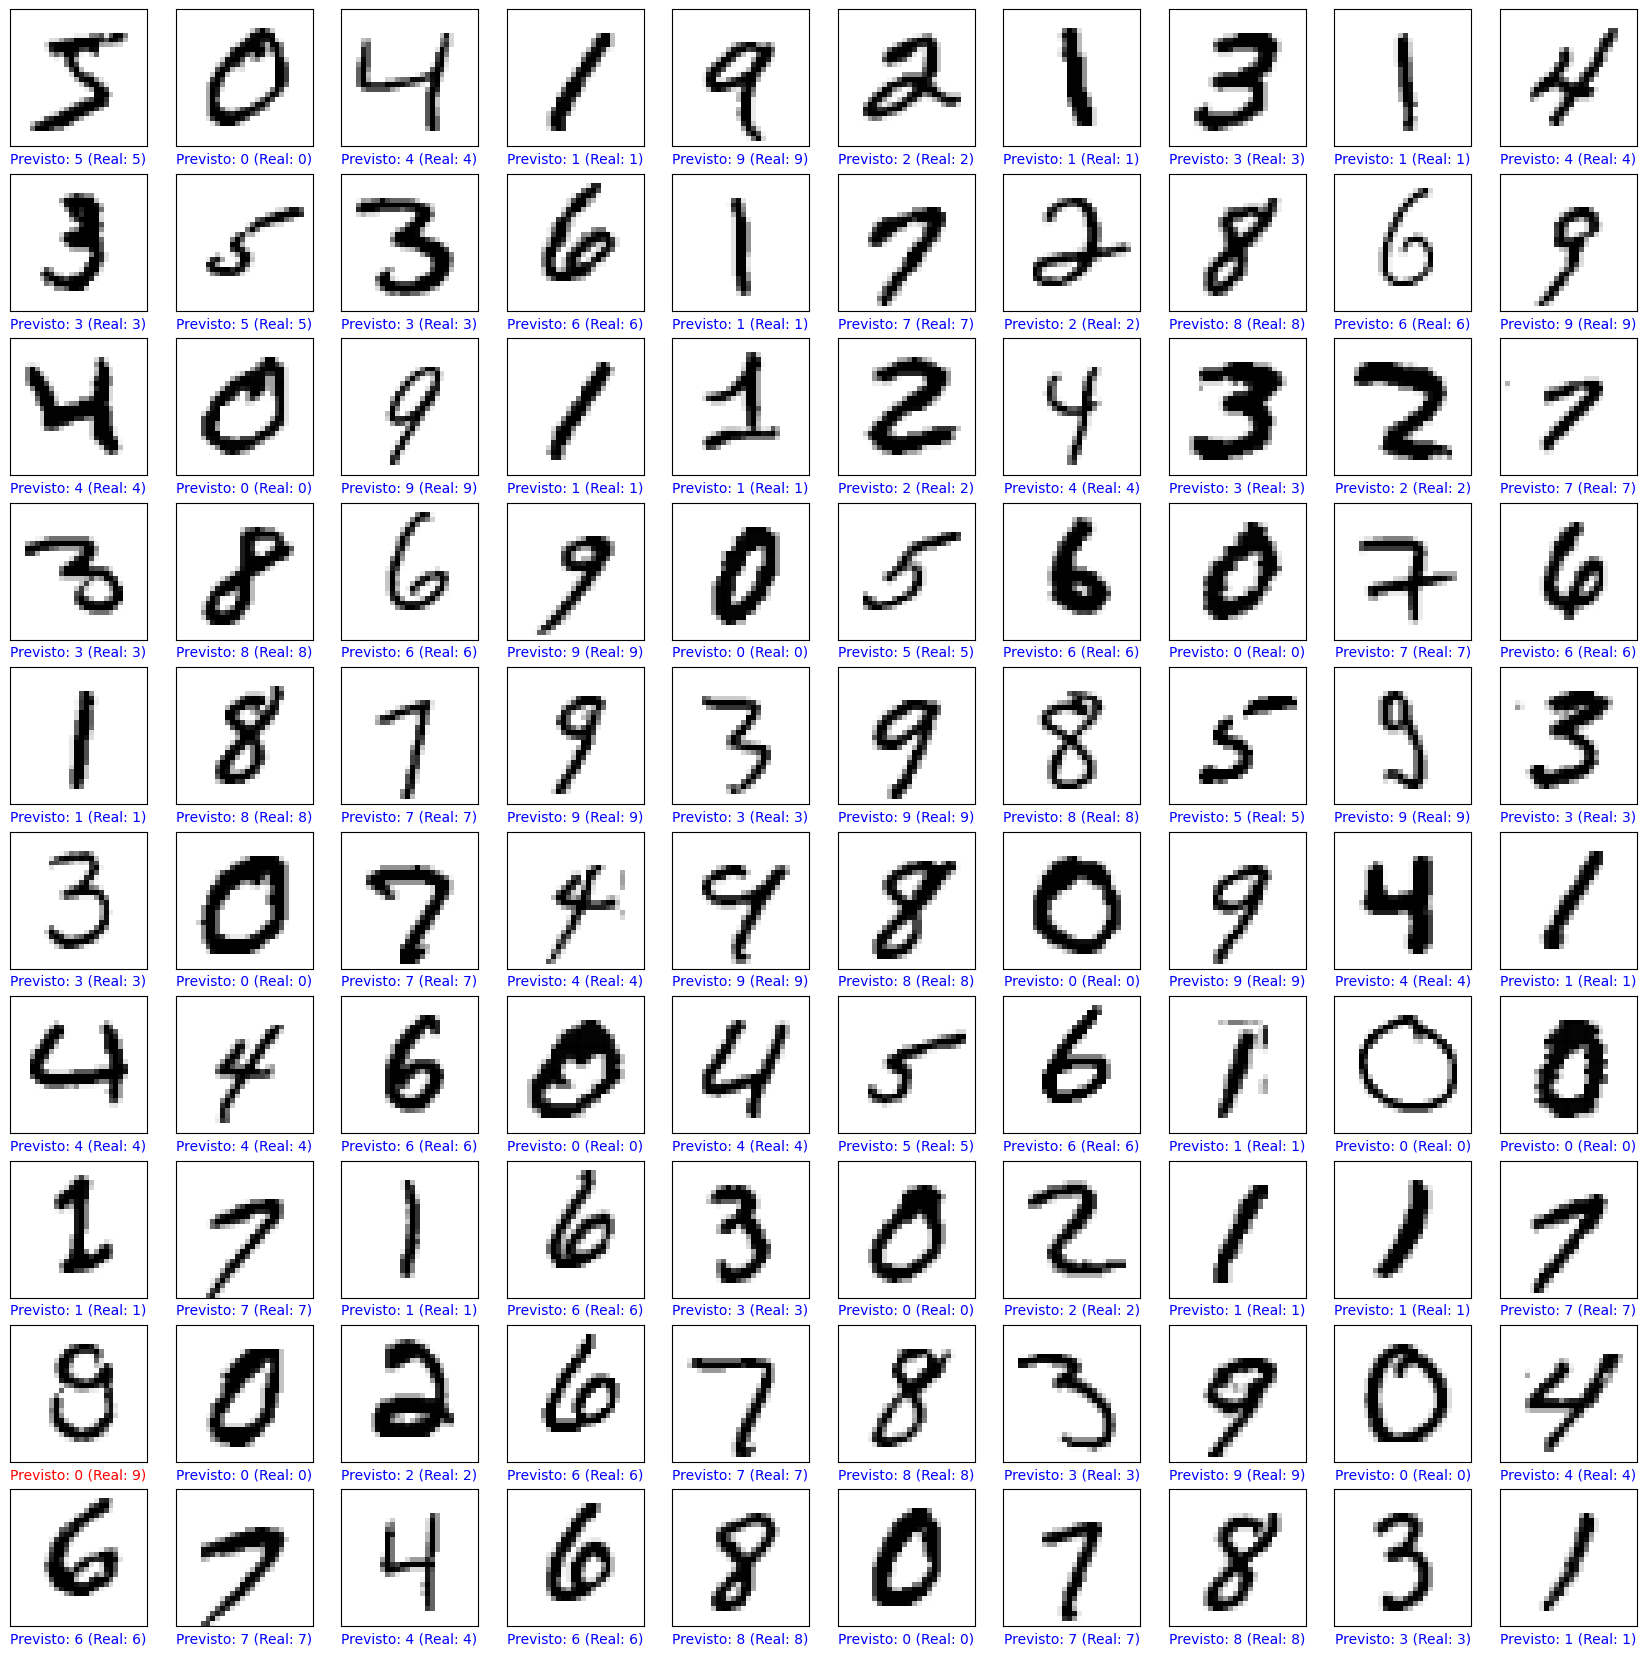

In [50]:
# Previsões para as primeiras n imagens do conjunto
predictions_trinta_ann = model_trinta.predict(x_trinta[:100])

# Visualização das previsões e dos rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_trinta[i], cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_trinta_ann[i])
  true_label = y_trinta[i]
  color = 'blue' if predicted_label == true_label else 'red'
  plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

## Prevendo 60000 instâncias

Como falamos, os dados do mnist estão separados. Como queremos 60000 instâncias, podemos usar os dados de treinamento.

In [51]:
print(x_tr.shape, y_tr.shape)

(60000, 28, 28) (60000,)


In [52]:
y_sessenta_ann_pred = model_trinta.predict(x_tr)
y_sessenta_ann_pred_labels = np.argmax(y_sessenta_ann_pred, axis=1)

1875/1875 [==============================] - 4s 2ms/step


## Matriz de confusão de acurácia

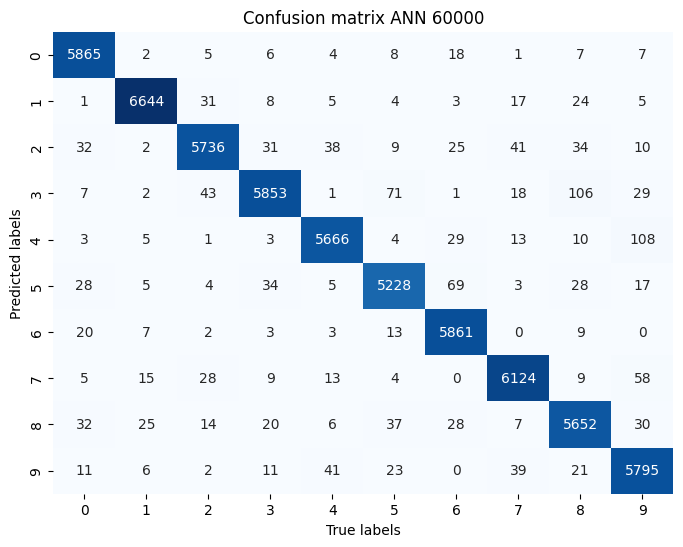

Acurácia: 0.973733


In [53]:
cm_sessenta_ann = confusion_matrix(y_tr, y_sessenta_ann_pred_labels)
nome_modelo = 'Confusion matrix ANN 60000'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sessenta_ann, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_tr
plt.ylabel('Predicted labels')  # y_sessenta_ann_pred_labels
plt.title(nome_modelo)
plt.show()

acc_sessenta_ann = accuracy_score(y_tr, y_sessenta_ann_pred_labels)
print('Acurácia:', round(acc_sessenta_ann, 6))

## Visualização

4/4 [==============================] - 0s 3ms/step


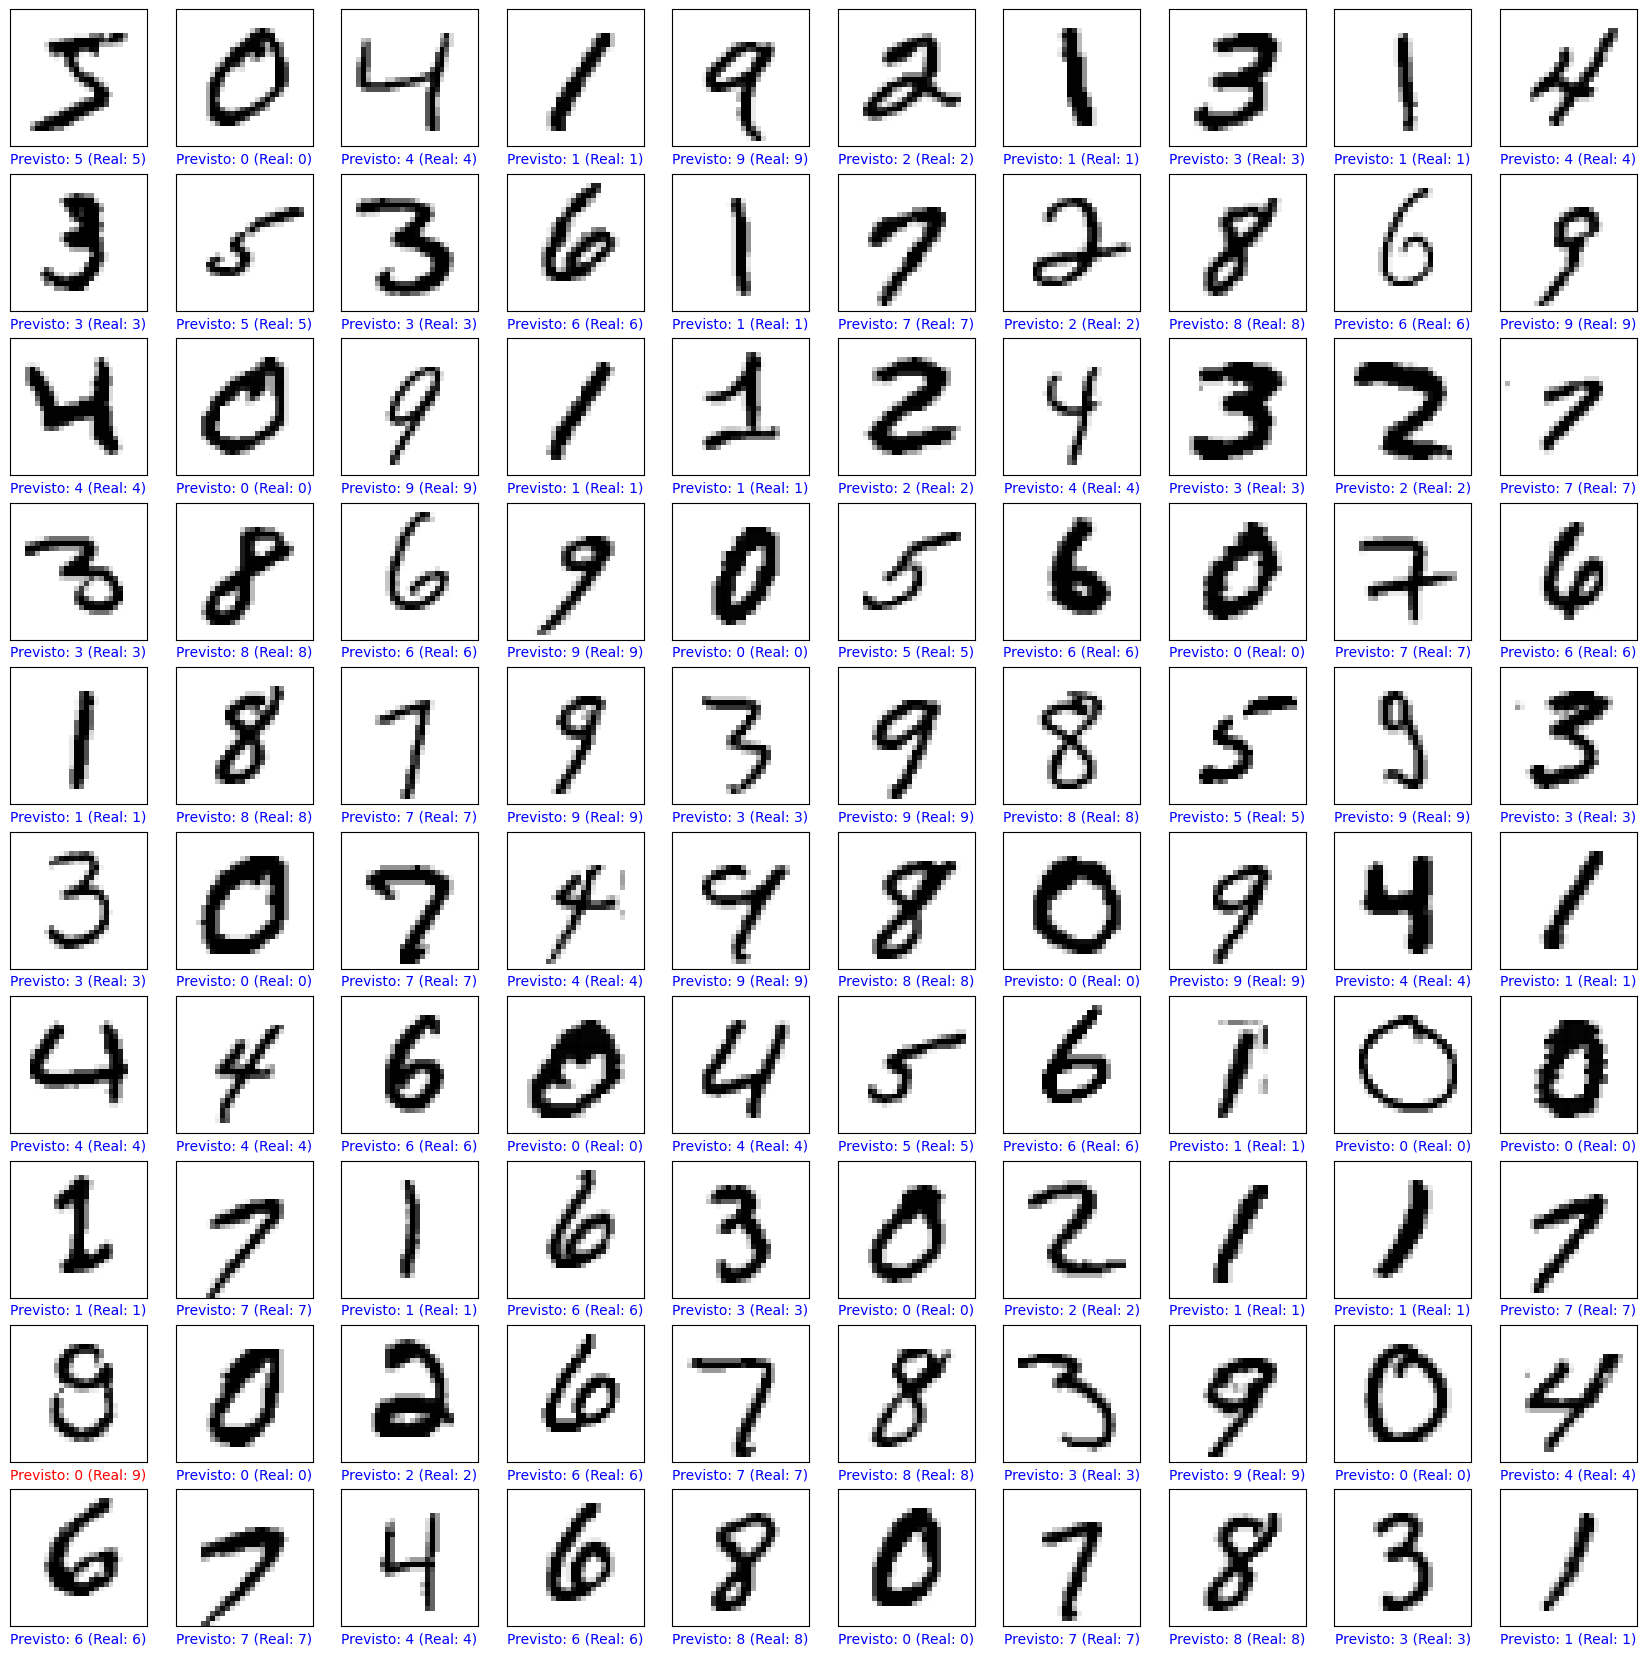

In [54]:
# Previsões para as primeiras n imagens do conjunto
predictions_sessenta_ann = model_trinta.predict(x_tr[:100])

# Visualização das previsões e dos rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_tr[i], cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_sessenta_ann[i])
  true_label = y_tr[i]
  color = 'blue' if predicted_label == true_label else 'red'
  plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Árvore com base na rede de 30000 instâncias

## Redimensionamento dos dados

In [55]:
n_samples = x_trinta.shape[0]                                           # Número de imagens
width = x_trinta.shape[1]                                               # Largura das imagens
height = x_trinta.shape[2]                                              # Altura das imagens
x_trinta_tree = np.reshape(x_trinta, (n_samples, width * height))       # Número de imagens, quantidade de pixels

## Split

Usando os rótulos previstos pela rede com 30000 instâncias.

In [56]:
x_trinta_tree_train, x_trinta_tree_test, y_trinta_tree_train, y_trinta_tree_test = train_test_split(x_trinta_tree, y_trinta_ann_pred_labels, test_size=0.25, random_state=0)

## Treinamento

In [57]:
classifier.fit(x_trinta_tree_train, y_trinta_tree_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

## Prevendo resultados

In [58]:
y_trinta_tree_pred = classifier.predict(x_trinta_tree)

## Matriz de confusão e acurácia

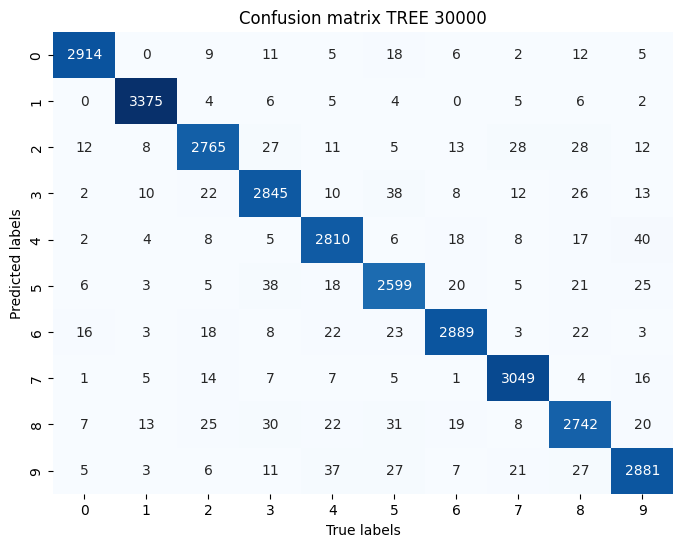

Acurácia: 0.9623


In [59]:
cm_trinta_tree = confusion_matrix(y_trinta_ann_pred_labels, y_trinta_tree_pred)
nome_modelo = 'Confusion matrix TREE 30000'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_trinta_tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_trinta_ann_pred_labels
plt.ylabel('Predicted labels')  # y_trinta_tree_pred
plt.title(nome_modelo)
plt.show()

acc_trinta_tree = accuracy_score(y_trinta_ann_pred_labels, y_trinta_tree_pred)
print('Acurácia:', round(acc_trinta_tree, 6))

## Visualização

In [60]:
x_trinta_tree_reshaped = x_trinta_tree.reshape(-1, 28, 28)

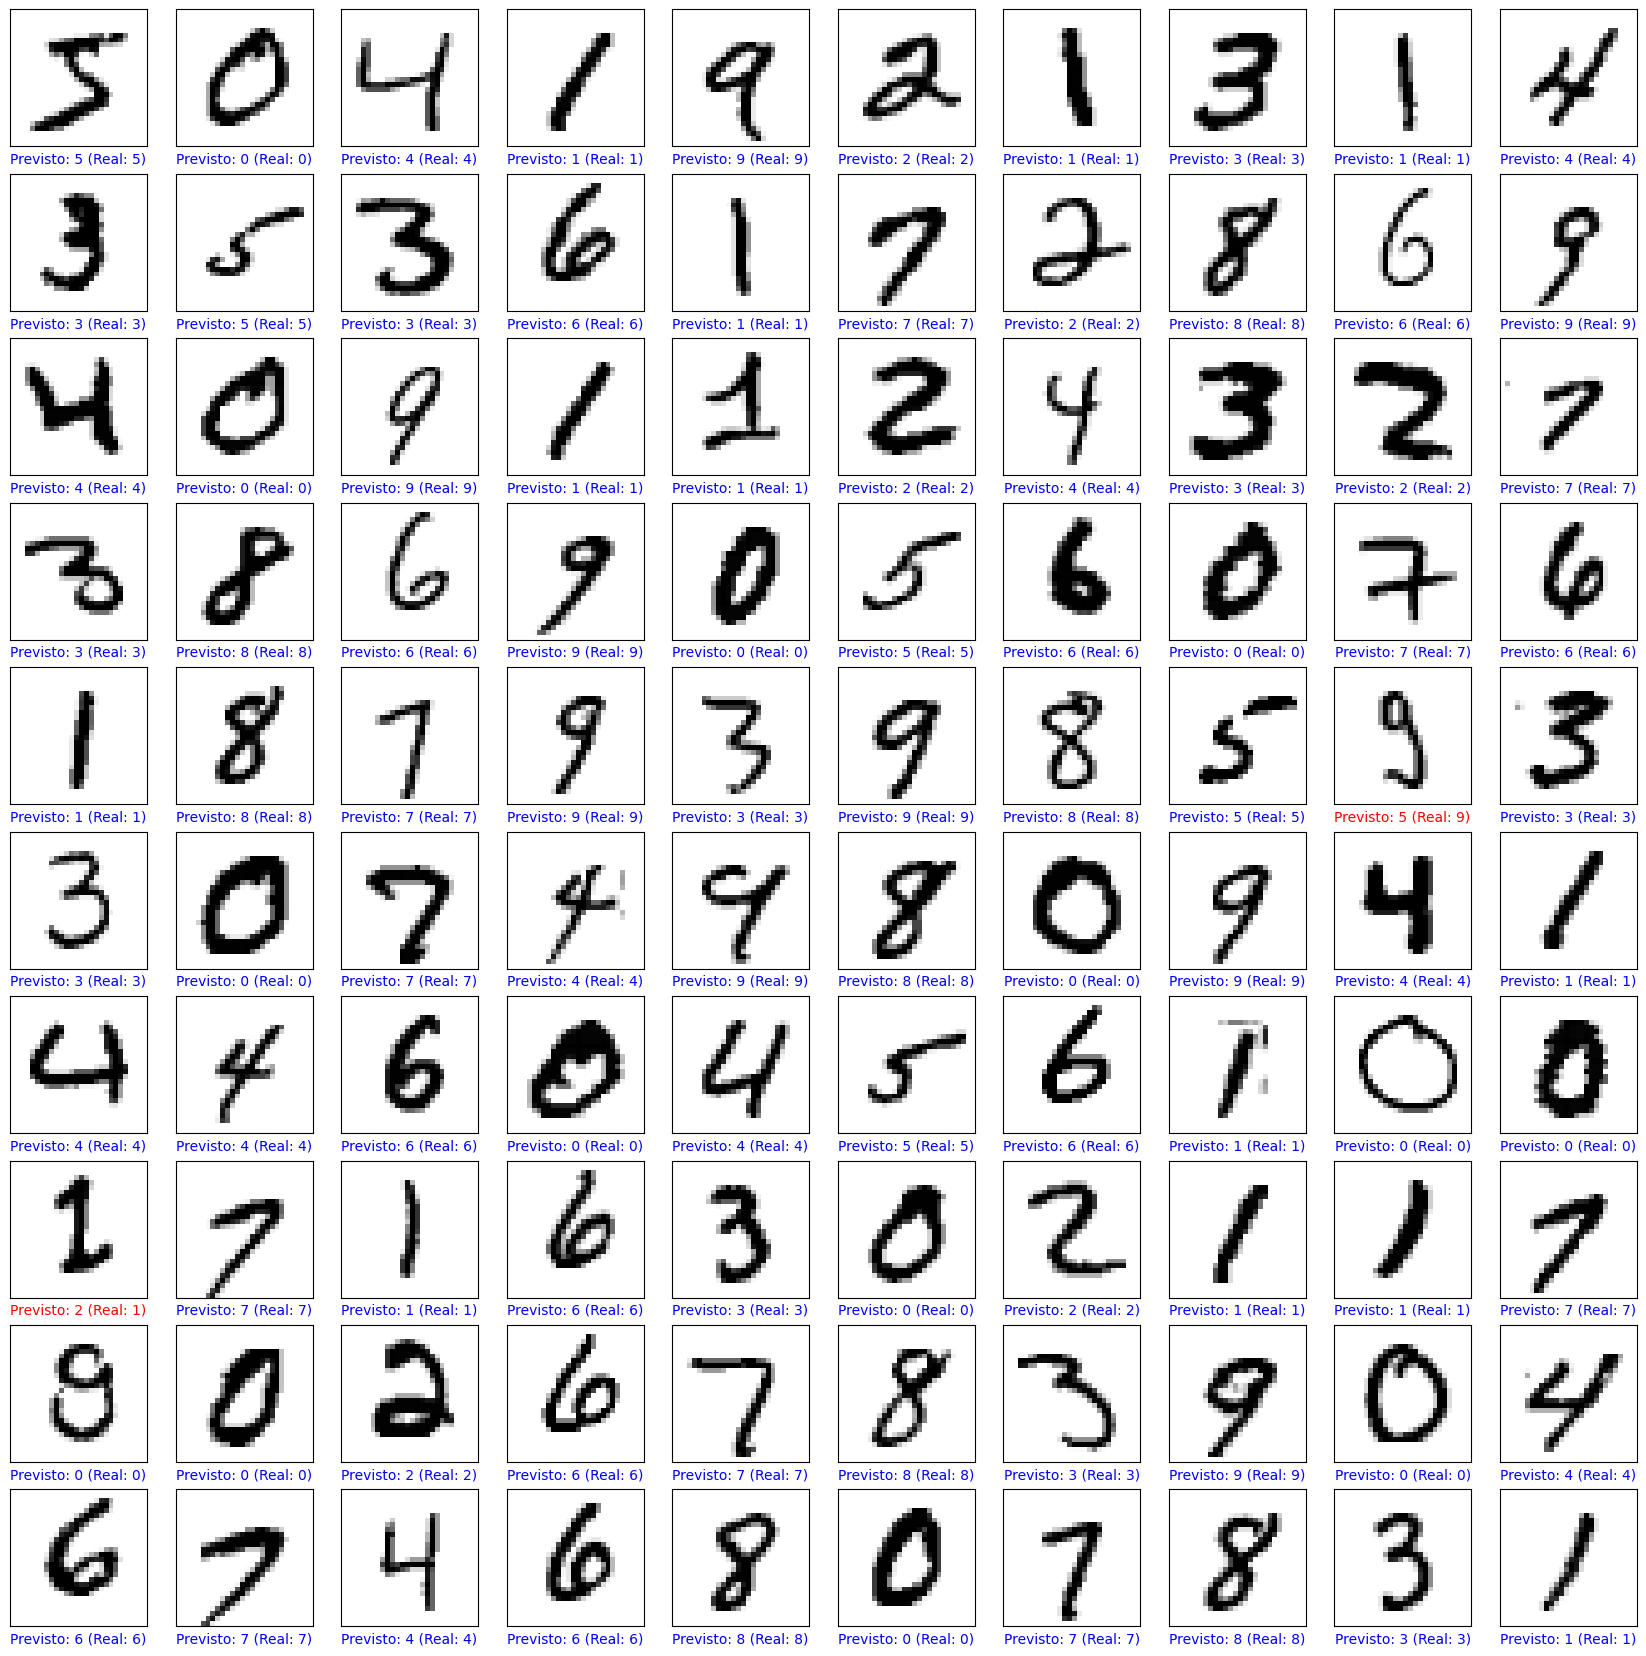

In [61]:
predictions_trinta_tree = classifier.predict(x_trinta_tree[:100])

# Visualizar as previsões e os rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_trinta_tree_reshaped[i], cmap=plt.cm.binary)
    predicted_label = predictions_trinta_tree[i]
    true_label = y_trinta_ann_pred_labels[i]
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Árvore com base na rede de 60000 instâncias

## Redimensionamento dos dados

In [62]:
n_samples = x_tr.shape[0]                                           # Número de imagens
width = x_tr.shape[1]                                               # Largura das imagens
height = x_tr.shape[2]                                              # Altura das imagens
x_sessenta_tree = np.reshape(x_tr, (n_samples, width * height))       # Número de imagens, quantidade de pixels

## Split

Usando os rótulos previstos pela rede de 60000 instâncias.

In [63]:
x_tr_tree_train, x_tr_tree_test, y_tr_tree_train, y_tr_tree_test = train_test_split(x_sessenta_tree, y_sessenta_ann_pred_labels, test_size=0.25, random_state=0)

## Treinamento

In [64]:
classifier.fit(x_tr_tree_train, y_tr_tree_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

## Prevendo resultados

In [65]:
y_sessenta_tree_pred = classifier.predict(x_sessenta_tree)

## Matriz de confusão e acurácia

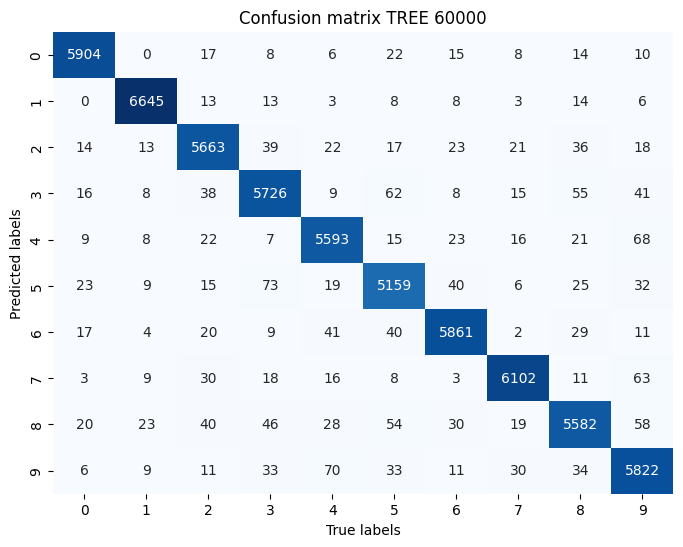

Acurácia: 0.967617


In [66]:
cm_sessenta_tree = confusion_matrix(y_sessenta_ann_pred_labels, y_sessenta_tree_pred)
nome_modelo = 'Confusion matrix TREE 60000'

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sessenta_tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('True labels')       # y_sessenta_ann_pred_labels
plt.ylabel('Predicted labels')  # y_sessenta_tree_pred
plt.title(nome_modelo)
plt.show()

acc_sessenta_tree = accuracy_score(y_sessenta_ann_pred_labels, y_sessenta_tree_pred)
print('Acurácia:', round(acc_sessenta_tree, 6))

## Visualização

In [67]:
x_sessenta_tree_reshaped = x_sessenta_tree.reshape(-1, 28, 28)

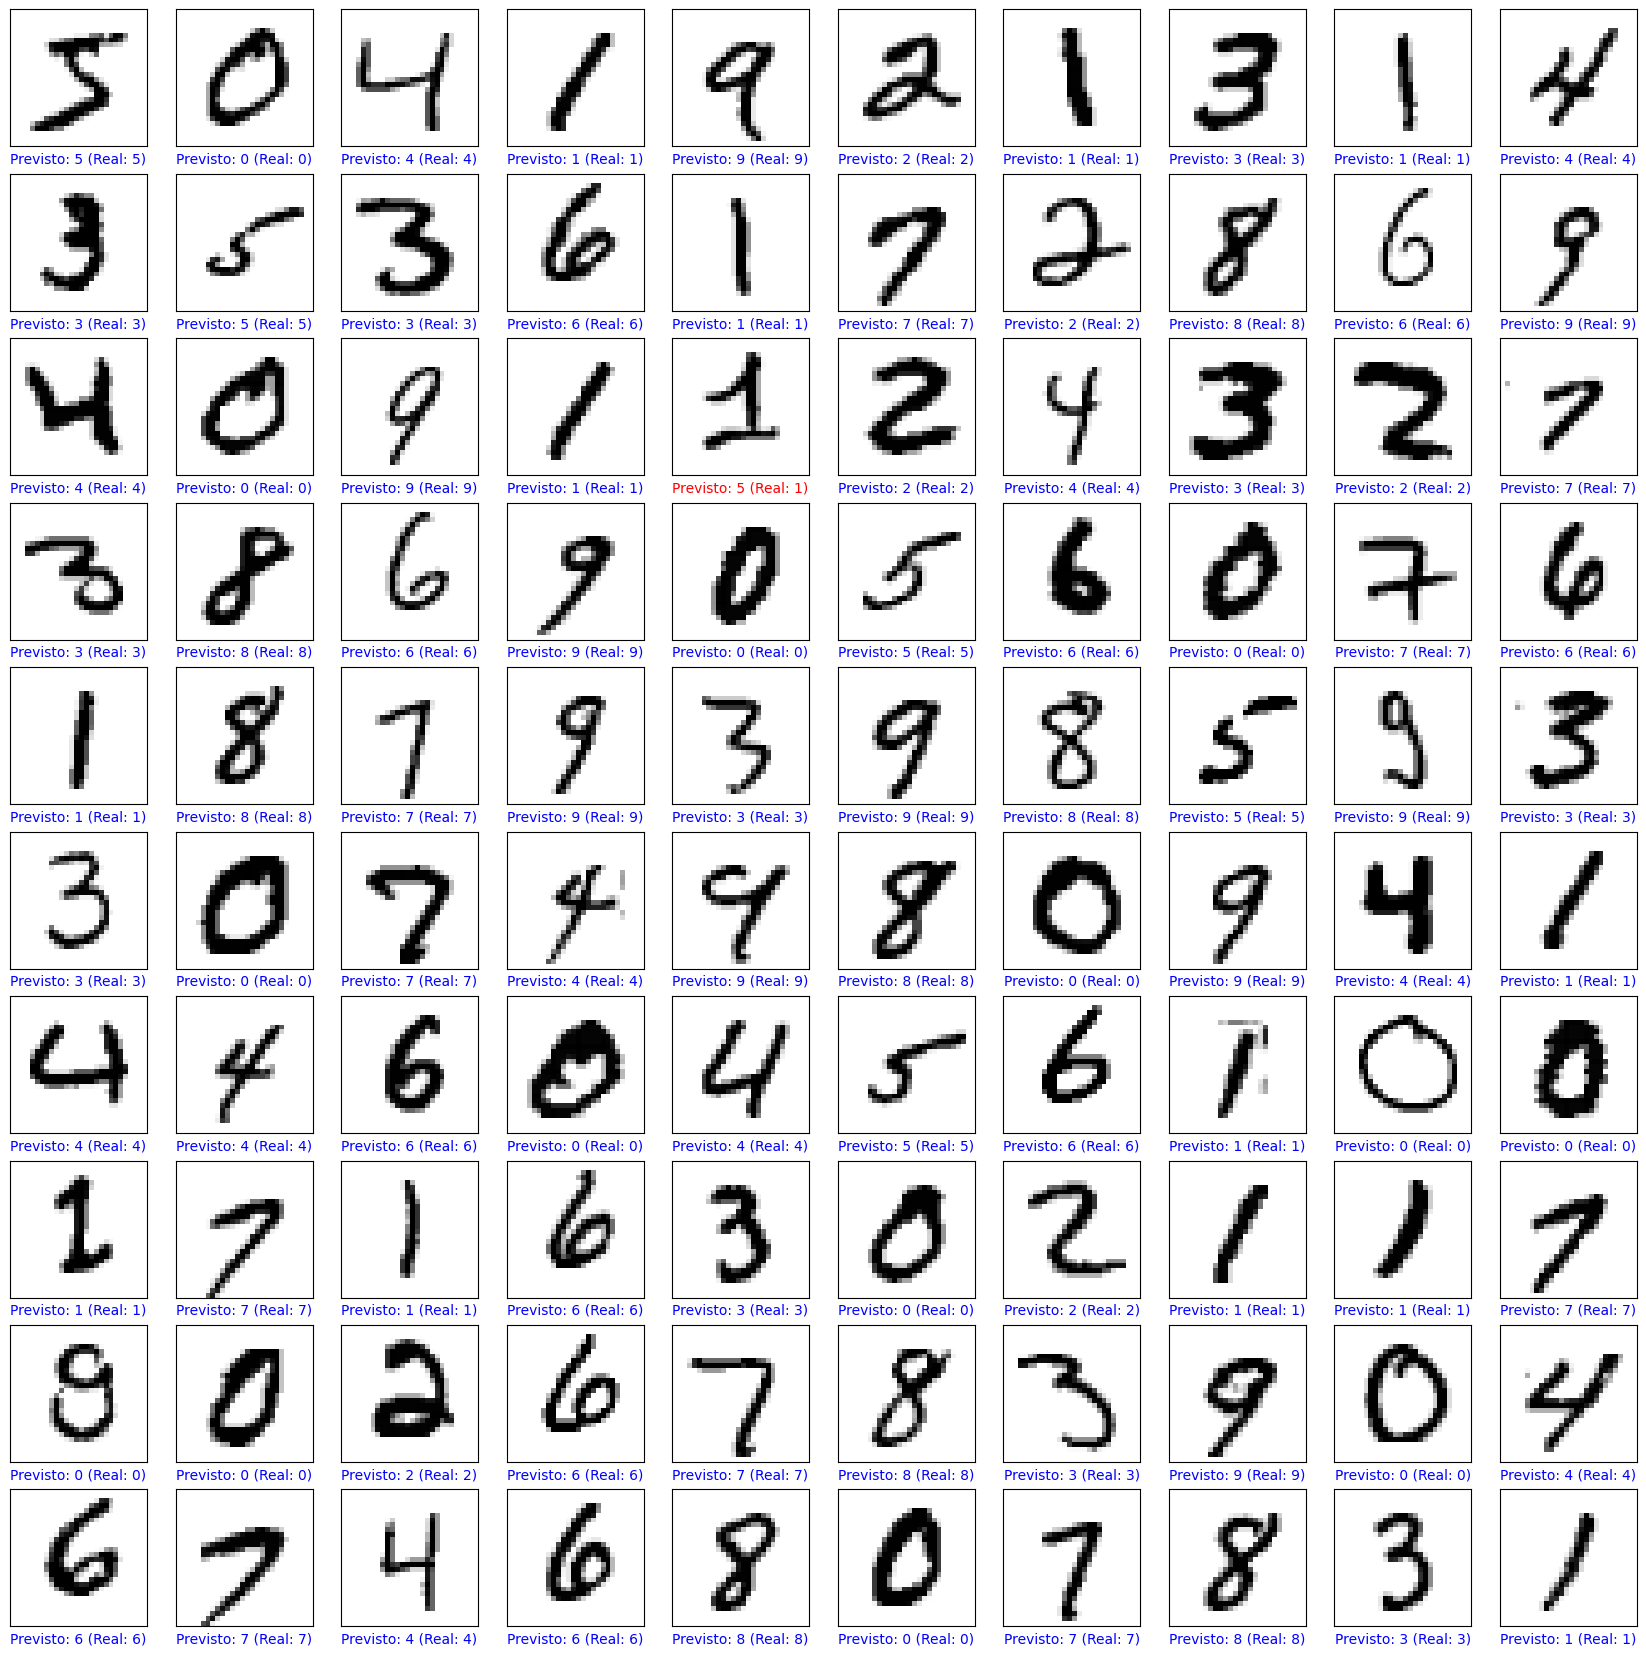

In [68]:
predictions_sessenta_tree = classifier.predict(x_sessenta_tree[:100])

# Visualizar as previsões e os rótulos reais
plt.figure(figsize=(21, 21))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_sessenta_tree_reshaped[i], cmap=plt.cm.binary)
    predicted_label = predictions_sessenta_tree[i]
    true_label = y_sessenta_ann_pred_labels[i]
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'Previsto: {predicted_label} (Real: {true_label})', color=color)
plt.show()

# Comparação das matrizes de confusão e das acurácias

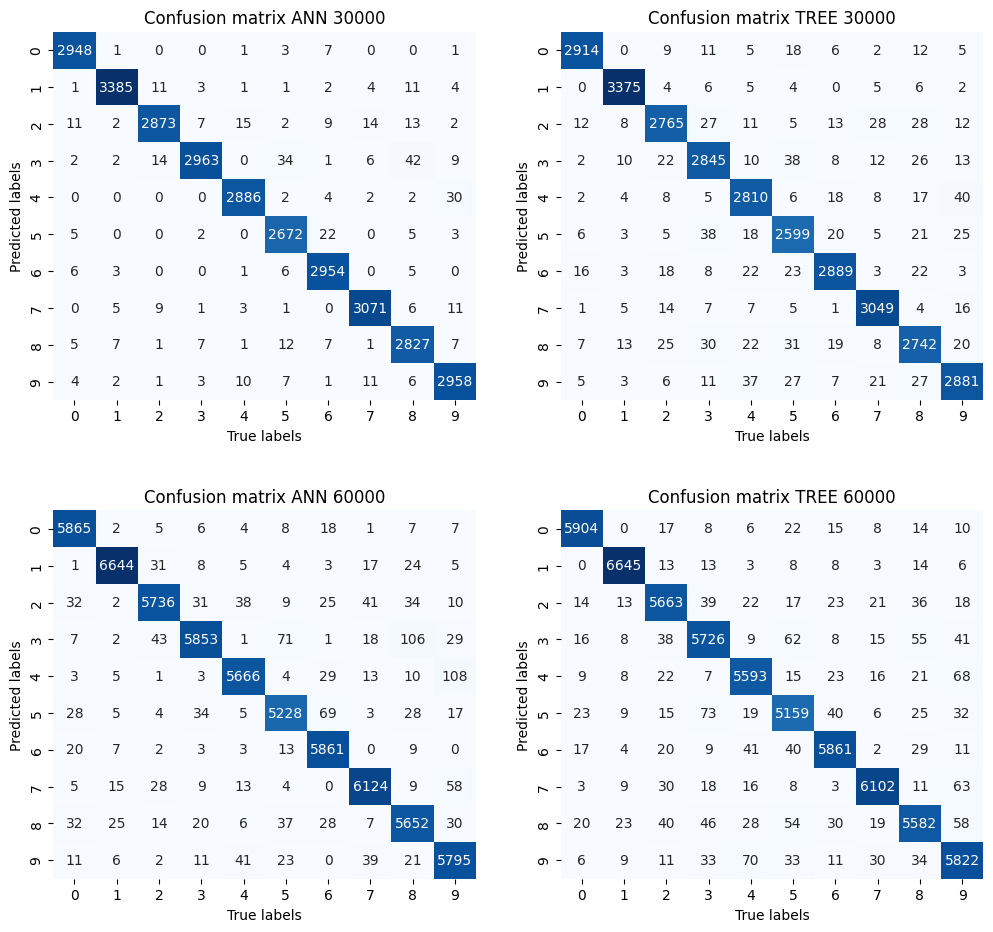

,Acuracia_30-ANN,Acuracia_30-TREE,Acuracia_60-ANN,Acuracia_60-TREE
0,0.984567,0.9623,0.973733,0.967617


In [69]:
matrizes_confusao = [cm_trinta_ann, cm_trinta_tree, cm_sessenta_ann, cm_sessenta_tree]
nomes_matrizes = ['Confusion matrix ANN 30000', 'Confusion matrix TREE 30000', 'Confusion matrix ANN 60000', 'Confusion matrix TREE 60000']

fig, axs = plt.subplots(2, 2, figsize=(12, 11))

for ax, cm, nome_modelo in zip(axs.flatten(), matrizes_confusao, nomes_matrizes):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.set_title(nome_modelo)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

acuracia = [(acc_trinta_ann, acc_trinta_tree, acc_sessenta_ann, acc_sessenta_tree)]
df = pd.DataFrame(acuracia, columns=('Acuracia_30-ANN', 'Acuracia_30-TREE', 'Acuracia_60-ANN', 'Acuracia_60-TREE'))
df